In [1]:
# script to make selection plots in AN/presentations for bkg distribution checks


import ROOT as rt
import csv
import re
import sys
import collections
import os
from collections import OrderedDict
import uproot
import pandas as pd
from root_numpy import array2tree


import scipy
import awkward
import numpy as np
import time
import numba
from numba import jit
from matplotlib import pyplot as plt
sys.path.append('/storage/af/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/lib/')
from histo_utilities import create_TH1D, create_TH2D, std_color_list, create_TGraph, make_ratio_plot
from helper_functions import deltaR, deltaPhi
import numpy as np
from scipy.stats import norm
import math
import CMS_lumi, tdrstyle
a= tdrstyle.setTDRStyle()
CMS_lumi.writeExtraText = 0

wH = 1
Z_MASS = 91.2



# donotdelete = []
print(sys.version)

Welcome to JupyROOT 6.18/02
3.6.8 (default, Aug  7 2019, 17:28:10) 
[GCC 4.8.5 20150623 (Red Hat 4.8.5-39)]


# Load ntuples

In [2]:
fpath =OrderedDict()
tree = OrderedDict()


start_t = time.time()
data_year = 'full'

v1 = 'V1p17'


v2 = '/v5/v163/'


data_path = '/storage/af/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/'+v1+'/Data2018/'+v2+'/normalized/'




if data_year == 2016:
    fpath['data'] = data_path + 'Run2_displacedJetMuonNtupler_'+v1+'_Data2016_Run2016-HighMET-07Aug17_goodLumi.root'
elif data_year == 2017:
    fpath['data'] = data_path + 'Run2_displacedJetMuonNtupler_'+v1+'_Data2017_Run2017-HighMET-17Nov2017_goodLumi.root'
elif data_year == 2018:
    fpath['data'] = data_path + 'Run2_displacedJetMuonNtupler_'+v1+'_Data2018_17Sept2018_Run2018-HighMET-17Sep2018_goodLumi.root'
else: #2016, 2017, 2018AB
    fpath['data'] = data_path + 'Run2_displacedJetMuonNtupler_'+v1+'_Data2016_Data2017_Data2018-HighMET_goodLumi.root'

decay = 'dddd'
mass = [  '7', '15', '40','55']
# ctaus  = ['100','1000','10000','100000']
ctaus  = ['1000']
for ct in ctaus:
    for m in mass:
        v2 = '/v1/v163'
        mc_path = '/storage/af/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/'+v1+'/MC_all'+v2+'/normalized/'
        fpath[decay+'_m'+m+'ctau'+ct] = mc_path + 'ggH_HToSSTo'+decay+'_MH-125_MS-'+str(m)+'_ctau-'+ct+'_137000pb_weighted.root'

# v2 = '/v2/v163'
# mc_path = '/storage/af/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/'+v1+'/MC_Fall18'+v2+'/normalized/'
# decay = 'PiPlusPiMinus'
# m_ct = ['ms0p4_pl10',  'ms0p4_pl50',  'ms1p0_pl125', 'ms1p0_pl25',  'ms2p0_pl250', 'ms2p0_pl50', 'ms4p0_pl100', 'ms4p0_pl500', ]


NEvents = {}
for k,v in fpath.items():
    print (k, v)
    root_dir = uproot.open(v) 

    tree[k] = root_dir['MuonSystem']
    NEvents[k] = root_dir['NEvents'][1]
    a = tree[k]["weight"].array()
    print("NEvents",NEvents[k])
    # 22743688.0


data /storage/af/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/V1p17/Data2018//v5/v163//normalized/Run2_displacedJetMuonNtupler_V1p17_Data2016_Data2017_Data2018-HighMET_goodLumi.root
NEvents 22763250.0
dddd_m7ctau1000 /storage/af/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/V1p17/MC_all/v1/v163/normalized/ggH_HToSSTodddd_MH-125_MS-7_ctau-1000_137000pb_weighted.root
NEvents 106227390.0
dddd_m15ctau1000 /storage/af/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/V1p17/MC_all/v1/v163/normalized/ggH_HToSSTodddd_MH-125_MS-15_ctau-1000_137000pb_weighted.root
NEvents 102585040.0
dddd_m40ctau1000 /storage/af/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/V1p17/MC_all/v1/v163/normalized/ggH_HToSSTodddd_MH-125_MS-40_ctau-1000_137000pb_weighted.root
NEvents 106752310.0
dddd_m55ctau1000 /storage/af/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/V1p17/MC_all/v1/v163/normalized/ggH_HToSSTodddd_MH-125_MS-55_ctau-1000_137000pb_weighted

(759,)

# load variables

In [3]:

JET_PT_CUT = 10.0
MUON_PT_CUT = 20.0
N_RECHIT_CUT = 90
jetPt_cut = 50
tightid = False
ring_cut = 50

cut_based = True
cut_based_version = 'v4'

intime = True
DPHI_CUT = 1


sel_ev = {}
cluster_index = ''
deltaRCluster = {}
cscClusterSize = {}
dtRechitClusterSize = {}

dtRechitClusterEta = {}
dtRechitClusterPhi = {}
dtRechitClusterAvgStation = {}
cscRechitClusterAvgStation = {}
dtRechitClusterDphi = {}
dtRechitClusterMetEENoise_dPhi = {}
dtRechitClusterAvgStation = {}
dtRechitCluster_match_RPCBx_dPhi0p5 = {}

dtRechitClusterNSegmentStation1 = {}
dtRechitClusterNSegmentStation2 = {}
dtRechitClusterNSegmentStation3 = {}
dtRechitClusterNSegmentStation4 = {}


cscRechitClusterTimeWeighted = {}
cscRechitClusterMetEENoise_dPhi = {}
cscRechitClusterEta = {}
cscRechitClusterPhi = {}
cscRechitClusterAvgStation = {}
deltaEta = {}
cond = {}
addNoiseFlag=0
category = 0
#2csc, 2dt, 1csc+1dt
for k, T in tree.items():
    if not k == 'data':continue

########### SELECTION: CLUSTERS ############
   
    sel_csccluster = T.array('cscRechitCluster' + cluster_index + 'TimeSpreadWeightedAll')<20
#     sel_csccluster = np.logical_and(sel_csccluster, np.abs(T.array('cscRechitCluster' + cluster_index + 'MetEENoise_dPhi'))<1.2)
    sel_csccluster = np.logical_and(sel_csccluster, T.array('cscRechitCluster' + cluster_index + 'JetVetoPt')<30)
    sel_csccluster = np.logical_and(sel_csccluster, T.array('cscRechitCluster' + cluster_index + 'Me11Ratio')<1)
    sel_csccluster = np.logical_and(sel_csccluster, np.logical_not(np.logical_and(T.array('cscRechitClusterMuonVetoPt') >= 30, T.array('cscRechitClusterMuonVetoGlobal'))))

#     sel_csccluster = np.logical_and(sel_csccluster, np.logical_and(T.array('cscRechitCluster' + cluster_index + 'TimeWeighted')< 12.5, \
#                                                                          T.array('cscRechitCluster' + cluster_index + 'TimeWeighted') > -5))
   
        
    sel_dtcluster = np.abs(T.array('dtRechitClusterMetEENoise_dPhi')) < 100000
    sel_dtcluster = np.logical_and(sel_dtcluster, np.logical_not(np.logical_and(T.array('dtRechitClusterMuonVetoPt') >= 10, T.array('dtRechitClusterMuonVetoLooseId'))))
    sel_dtcluster = np.logical_and(sel_dtcluster, np.abs(T.array('dtRechitClusterJetVetoPt')) < 50)
    sel_dtcluster = np.logical_and(sel_dtcluster, np.logical_not(np.logical_and(T.array('dtRechitClusterMaxStation')==1, T.array('dtRechitClusterMaxStationRatio')>0.9)))
    
    
    cut = 5
    station = (T.array('dtRechitClusterNSegmentStation1')>cut).astype(int)+(T.array('dtRechitClusterNSegmentStation2')>cut).astype(int)\
+(T.array('dtRechitClusterNSegmentStation3')>cut).astype(int)+(T.array('dtRechitClusterNSegmentStation4')>cut).astype(int)

    max_station = np.maximum(np.maximum(np.maximum(T.array('dtRechitClusterNSegmentStation1'), T.array('dtRechitClusterNSegmentStation2')), T.array('dtRechitClusterNSegmentStation3')), T.array('dtRechitClusterNSegmentStation4'))
    min_station = np.minimum(np.minimum(np.minimum(T.array('dtRechitClusterNSegmentStation1'), T.array('dtRechitClusterNSegmentStation2')), T.array('dtRechitClusterNSegmentStation3')), T.array('dtRechitClusterNSegmentStation4'))

    sel_dtcluster = np.logical_and(sel_dtcluster, np.logical_or(station<4, min_station/max_station<0.4)) #remove if both clusters are 4 stations
    
#     ###################### cosmic muon veto #############
    sel_cosmic = np.logical_and(T.array('dtRechitClusterNOppositeSegStation1')>0, T.array('dtRechitClusterNOppositeSegStation2')>0)
    sel_cosmic = np.logical_and(sel_cosmic, T.array('dtRechitClusterNOppositeSegStation3')>0)
    sel_cosmic = np.logical_and(sel_cosmic, T.array('dtRechitClusterNOppositeSegStation4')>0)
    sel_cosmic = np.logical_and(sel_cosmic, T.array('dtRechitClusterNOppositeSegStation1')+T.array('dtRechitClusterNOppositeSegStation2')+\
                               T.array('dtRechitClusterNOppositeSegStation3')+T.array('dtRechitClusterNOppositeSegStation4')>=6)
    nstation = (T.array('dtRechitClusterNSegmentStation1')>1).astype(int)+(T.array('dtRechitClusterNSegmentStation2')>1).astype(int)\
    +(T.array('dtRechitClusterNSegmentStation3')>1).astype(int)+(T.array('dtRechitClusterNSegmentStation4')>1).astype(int)
    
    sel_dtcluster = np.logical_and(sel_dtcluster, np.logical_not(np.logical_and(nstation>=3, sel_cosmic)))
########### SELECTION: JETS ############
    
    sel_jet = np.logical_and(T.array('jetPt') > 30, np.abs(T.array('jetEta')) < 2.4 )
    sel_jet = np.logical_and(T.array('jetTightPassId'), sel_jet)


            
########### SELECTION: NOISE IN DT ############
    
    spike = np.logical_and( T.array('nDTRechitsSector')[:,0,0,7]>50,  T.array('nDTRechitsSector')[:,0,0,7]+T.array('nDTRechitsSector')[:,0,0,8]+T.array('nDTRechitsSector')[:,0,0,9]>120)
    spike = np.logical_and(spike, T.array('nDTRechitsSector')[:,0,0,8]>25)
    spike = np.logical_and(spike, T.array('nDTRechitsSector')[:,0,0,9]>10)

    
    
########### SELECTION: EVENTS ############

    sel_ev[k] = T.array('METNoMuTrigger')
    sel_ev[k] = np.logical_and(sel_ev[k] ,T.array('metEENoise') >= 200)
    sel_ev[k] = np.logical_and(sel_ev[k] , sel_jet.sum()>=1)
    sel_ev[k] = np.logical_and(sel_ev[k], (T.array('nDtRings')+T.array('nCscRings'))<10)
    sel_ev[k] = np.logical_and(sel_ev[k],T.array('Flag2_all'))
    sel_ev[k] = np.logical_and(sel_ev[k] , np.logical_not(spike))

########### BRANCHES ############

                            
    if category == 0:
        sel_ev[k]  = np.logical_and(sel_ev[k],sel_csccluster.sum()== 2)
        sel_ev[k]  = np.logical_and(sel_ev[k],sel_dtcluster.sum()== 0)
        
        
#         cond[k] = deltaR(T.array('cscRechitCluster' + cluster_index + 'Eta')[sel_csccluster][sel_ev[k]][:,0], \
#                          T.array('cscRechitCluster' + cluster_index + 'Phi')[sel_csccluster][sel_ev[k]][:,0],\
#                         T.array('cscRechitCluster' + cluster_index + 'Eta')[sel_csccluster][sel_ev[k]][:,1], \
#                          T.array('cscRechitCluster' + cluster_index + 'Phi')[sel_csccluster][sel_ev[k]][:,1])>=0
        
       
#         nhits1[k] =  T.array('cscRechitCluster' + cluster_index + 'Size')[sel_csccluster][sel_ev[k]][cond[k]][:,0]
#         nhits2[k] =  T.array('cscRechitCluster' + cluster_index + 'Size')[sel_csccluster][sel_ev[k]][cond[k]][:,1]
        deltaRCluster[k] = deltaR(T.array('cscRechitCluster' + cluster_index + 'Eta')[sel_csccluster][sel_ev[k]][:,0], T.array('cscRechitCluster' + cluster_index + 'Phi')[sel_csccluster][sel_ev[k]][:,0],\
                        T.array('cscRechitCluster' + cluster_index + 'Eta')[sel_csccluster][sel_ev[k]][:,1], T.array('cscRechitCluster' + cluster_index + 'Phi')[sel_csccluster][sel_ev[k]][:,1])
        cscClusterSize[k] =  T.array('cscRechitCluster' + cluster_index + 'Size')[sel_csccluster][sel_ev[k]][:,:]
        cscRechitClusterTimeWeighted[k] =  T.array('cscRechitCluster' + cluster_index + 'TimeWeighted')[sel_csccluster][sel_ev[k]][:,:]
        cscRechitClusterPhi[k] =  T.array('cscRechitCluster' + cluster_index + 'Phi')[sel_csccluster][sel_ev[k]]  
        cscRechitClusterAvgStation[k] =  T.array('cscRechitCluster' + cluster_index + 'AvgStation10')[sel_csccluster][sel_ev[k]]  
        cscRechitClusterEta[k] =  T.array('cscRechitCluster' + cluster_index + 'Eta')[sel_csccluster][sel_ev[k]]  
        cscRechitClusterMetEENoise_dPhi[k] = T.array('cscRechitCluster' + cluster_index + 'MetEENoise_dPhi')[sel_csccluster][sel_ev[k]]  
        cscRechitClusterAvgStation[k] =  T.array('cscRechitClusterAvgStation10')[sel_csccluster][sel_ev[k]][:,:]

    elif category == 1:
        sel_ev[k]  = np.logical_and(sel_ev[k],sel_dtcluster.sum()== 2)
        sel_ev[k]  = np.logical_and(sel_ev[k],sel_csccluster.sum()== 0)
#         cond[k] = np.abs(T.array('dtRechitCluster' + cluster_index + 'Eta')[sel_dtcluster][sel_ev[k]][:,0]-\
#                                                     T.array('dtRechitCluster' + cluster_index + 'Eta')[sel_dtcluster][sel_ev[k]][:,1])>=0
#         if addNoiseFlag and not 'data' in k:
#             nhits1[k] =  (T.array('dtRechitClusterNoiseHit')+T.array('dtRechitClusterSize'))[sel_dtcluster][sel_ev[k]][:,0]
#             nhits2[k] =  (T.array('dtRechitClusterNoiseHit')+T.array('dtRechitClusterSize'))[sel_dtcluster][sel_ev[k]][:,1]
#         else:
#             nhits1[k] =  T.array('dtRechitClusterSize')[sel_dtcluster][sel_ev[k]][:,0]
#             nhits2[k] =  T.array('dtRechitClusterSize')[sel_dtcluster][sel_ev[k]][:,1]
#         dtRechitCluster_match_RPCBx_dPhi0p5[k] = T.array('dtRechitCluster_match_RPCBx_dPhi0p5')[sel_dtcluster][sel_ev[k]][:,:]
#         dtRechitCluster_match_RPChits_dPhi0p5[k] = T.array('dtRechitCluster_match_RPChits_dPhi0p5')[sel_dtcluster][sel_ev[k]][:,:]
        dtRechitClusterSize[k] =  T.array('dtRechitClusterSize')[sel_dtcluster][sel_ev[k]][:,:]
        dtRechitClusterEta[k] =  T.array('dtRechitClusterEta')[sel_dtcluster][sel_ev[k]][:,:]
        dtRechitClusterPhi[k] =  T.array('dtRechitClusterPhi')[sel_dtcluster][sel_ev[k]][:,:]
        dtRechitClusterAvgStation[k] =  np.abs(T.array('dtRechitClusterAvgStation10')[sel_dtcluster][sel_ev[k]][:,:])
        dtRechitClusterMetEENoise_dPhi[k] =  T.array('dtRechitClusterMetEENoise_dPhi')[sel_dtcluster][sel_ev[k]][:,:]
        dtRechitClusterNSegmentStation1[k] =  T.array('dtRechitClusterNSegmentStation1')[sel_dtcluster][sel_ev[k]][:,:]
        dtRechitClusterNSegmentStation2[k] =  T.array('dtRechitClusterNSegmentStation2')[sel_dtcluster][sel_ev[k]][:,:]
        dtRechitClusterNSegmentStation3[k] =  T.array('dtRechitClusterNSegmentStation3')[sel_dtcluster][sel_ev[k]][:,:]
        dtRechitClusterNSegmentStation4[k] =  T.array('dtRechitClusterNSegmentStation4')[sel_dtcluster][sel_ev[k]][:,:]
    elif category == 2:
        sel_ev[k]  = np.logical_and(sel_ev[k],sel_csccluster.sum() == 1)
        sel_ev[k]  = np.logical_and(sel_ev[k],sel_dtcluster.sum() == 1)
        
#         cond[k] =  np.abs(T.array('cscRechitCluster' + cluster_index + 'Eta')[sel_csccluster][sel_ev[k]][:,0]-\
#                                                     T.array('dtRechitCluster' + cluster_index + 'Eta')[sel_dtcluster][sel_ev[k]][:,0])<2.0
       
#         cond[k] = deltaR(T.array('cscRechitCluster' + cluster_index + 'Eta')[sel_csccluster][sel_ev[k]][:,0], T.array('cscRechitCluster' + cluster_index + 'Phi')[sel_csccluster][sel_ev[k]][:,0],\
#                         T.array('dtRechitCluster' + cluster_index + 'Eta')[sel_dtcluster][sel_ev[k]][:,0], T.array('dtRechitCluster' + cluster_index + 'Phi')[sel_dtcluster][sel_ev[k]][:,0])<2.5
#         if addNoiseFlag and not 'data' in k:
#             nhits1[k] =  (T.array('dtRechitClusterNoiseHit')+T.array('dtRechitClusterSize'))[sel_dtcluster][sel_ev[k]][cond[k]][:,0]
#         else:
#             nhits1[k] =  T.array('dtRechitClusterSize')[sel_dtcluster][sel_ev[k]][cond[k]][:,0]
#         nhits2[k] =  T.array('cscRechitCluster' + cluster_index + 'Size')[sel_csccluster][sel_ev[k]][cond[k]][:,0]
        
#         dtRechitCluster_match_RPCBx_dPhi0p5[k] = T.array('dtRechitCluster_match_RPCBx_dPhi0p5')[sel_dtcluster][sel_ev[k]][:,0]

        dtRechitClusterPhi[k] = T.array('dtRechitClusterPhi')[sel_dtcluster][sel_ev[k]][:,0]
        dtRechitClusterEta[k] = T.array('dtRechitClusterEta')[sel_dtcluster][sel_ev[k]][:,0]
        dtRechitClusterAvgStation[k] = T.array('dtRechitClusterAvgStation10')[sel_dtcluster][sel_ev[k]][:,0]
        dtRechitClusterSize[k] =  T.array('dtRechitClusterSize')[sel_dtcluster][sel_ev[k]][:,0]
#         dtRechitClusterNStation[k] =  T.array('dtRechitClusterNStation10')[sel_dtcluster][sel_ev[k]][:,0]

        cscRechitClusterAvgStation[k] = T.array('cscRechitCluster' + cluster_index + 'AvgStation10')[sel_csccluster][sel_ev[k]][:,0]

        cscRechitClusterTimeWeighted[k] =  T.array('cscRechitCluster' + cluster_index + 'TimeWeighted')[sel_csccluster][sel_ev[k]][:,0]
        
        cscRechitClusterPhi[k] = T.array('cscRechitCluster' + cluster_index + 'Phi')[sel_csccluster][sel_ev[k]][:,0]
        cscRechitClusterEta[k] = T.array('cscRechitCluster' + cluster_index + 'Eta')[sel_csccluster][sel_ev[k]][:,0]
        cscClusterSize[k] =  T.array('cscRechitCluster' + cluster_index + 'Size')[sel_csccluster][sel_ev[k]][:,0]
#         cscRechitClusterTime[k] =  T.array('cscRechitCluster' + cluster_index + 'TimeTotal')[sel_csccluster][sel_ev[k]][:,0]

        dtRechitClusterNSegmentStation1[k] =  T.array('dtRechitClusterNSegmentStation1')[sel_dtcluster][sel_ev[k]][:,0]
        dtRechitClusterNSegmentStation2[k] =  T.array('dtRechitClusterNSegmentStation2')[sel_dtcluster][sel_ev[k]][:,0]
        dtRechitClusterNSegmentStation3[k] =  T.array('dtRechitClusterNSegmentStation3')[sel_dtcluster][sel_ev[k]][:,0]
        dtRechitClusterNSegmentStation4[k] =  T.array('dtRechitClusterNSegmentStation4')[sel_dtcluster][sel_ev[k]][:,0]


In [285]:
category

0

# CSC Cluster Plots

129.0


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /storage/af/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/double_tag/selection_plots_final//v1/v163/csccsc_clusterDPhi_intime.png has been created
Info in <TCanvas::Print>: pdf file /storage/af/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/double_tag/selection_plots_final//v1/v163/csccsc_clusterDPhi_intime.pdf has been created
Info in <TCanvas::SaveSource>: C++ Macro file: /storage/af/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/double_tag/selection_plots_final//v1/v163/csccsc_clusterDPhi_intime.C has been generated


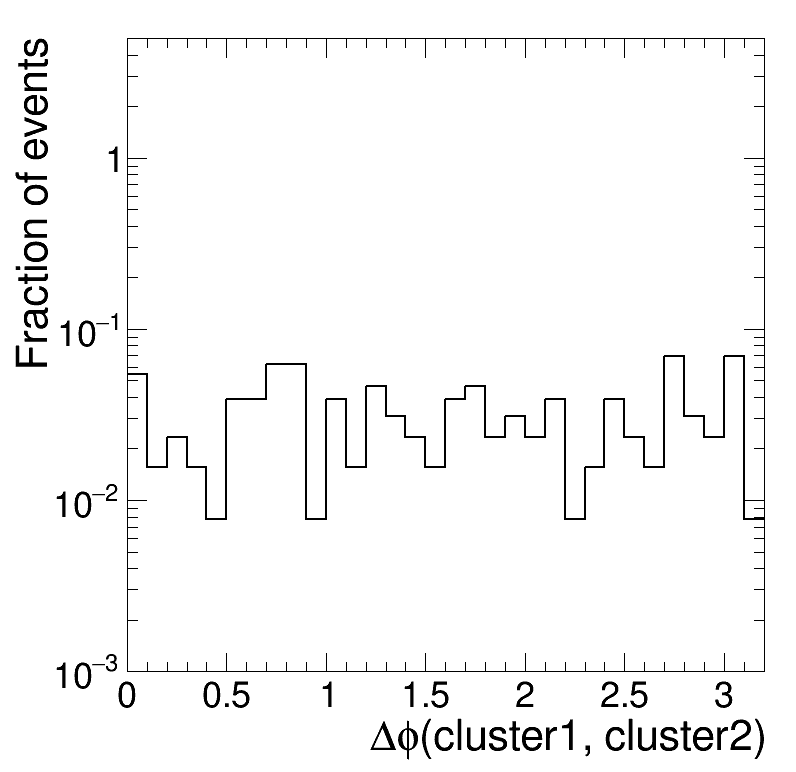

In [286]:
assert(category == 0)


var = [cscRechitClusterTimeWeighted, cscRechitClusterEta, cscRechitClusterPhi, cscRechitClusterAvgStation]
name = ['cscRechitClusterTimeWeighted', 'cscRechitClusterEta', 'clusterDPhi', 'cscRechitClusterAvgStation']

xaxis = ['cluster time [ns]', 'cluster #eta', '#Delta#phi(cluster1, cluster2)','CSC cluster average station']


# bins = [ [100,-100,120], [50,0,100], [50,0,500],[50,0,200], [32,0,3.2], [25,0,1.1],[25,0.8,2.5],[30,0,3.2],[35,1,4], [40,0,3.2], [40,0,8], [40,0,5]]

bins = [ [100,-100,120], [25,0.8,2.5], [32,0,3.2], [20,1,5]]

setlogy = [1,1, 1,1]
time_cut = 1
for index in range(len(var)):
    if not index == 2:continue
    c = rt.TCanvas('c','c', 800, 800)
    leg = rt.TLegend(0.6,0.7,0.80,0.92)


    leg.SetTextSize(0.03)
    leg.SetBorderSize(0)
    leg.SetEntrySeparation(0.01)
    h = {}

    for i, k in enumerate(cscClusterSize.keys()):
        sel_csccluster =  cscClusterSize[k]<1000000
        if index == 0:
            sel_csccluster =  np.logical_and(sel_csccluster, np.abs(cscRechitClusterMetEENoise_dPhi[k])<1.2)
            sel_csccluster =  np.logical_and(sel_csccluster, np.abs(deltaRCluster[k])<2)
        elif index == 1:
#             sel_csccluster =  np.logical_and(sel_csccluster, np.abs(cscRechitClusterMetEENoise_dPhi[k])<1.2)
#             sel_csccluster =  np.logical_and(sel_csccluster, np.abs(deltaRCluster[k])<20000)
            if time_cut:
                sel_csccluster =  np.logical_and(sel_csccluster, cscRechitClusterTimeWeighted[k]<12.5)
                sel_csccluster =  np.logical_and(sel_csccluster, cscRechitClusterTimeWeighted[k]>-5)
        elif index == 2:
            sel_csccluster =  np.logical_and(sel_csccluster, cscRechitClusterTimeWeighted[k]<12.5)
            sel_csccluster =  np.logical_and(sel_csccluster, cscRechitClusterTimeWeighted[k]>-5)
        elif index == 3:
            sel_csccluster =  np.logical_and(sel_csccluster, cscRechitClusterTimeWeighted[k]<12.5)
            sel_csccluster =  np.logical_and(sel_csccluster, cscRechitClusterTimeWeighted[k]>-5)
#             sel_csccluster =  np.logical_and(sel_csccluster, np.abs(cscRechitClusterMetEENoise_dPhi[k])<1.2)
#             sel_csccluster =  np.logical_and(sel_csccluster, np.abs(deltaRCluster[k])<2)
        cond = sel_csccluster.sum()==2
        if k == 'data':
            cond= np.logical_and(cond, cscClusterSize[k].min()<100)
        if category == 0:
            if not index == 2:h[k] = create_TH1D(np.hstack((var[index][k][sel_csccluster][cond][:,0], var[index][k][sel_csccluster][cond][:,1])), axis_title = [xaxis[index], 'Fraction of events'], binning = bins[index])
            else: h[k] = create_TH1D(np.abs(deltaPhi(var[index][k][sel_csccluster][cond][:,0], var[index][k][sel_csccluster][cond][:,1])), axis_title = [xaxis[index], 'Fraction of events'], binning = bins[index])
                #             else: h[k] = create_TH1D(var[index][k][sel_csccluster][cond].max(), axis_title = [xaxis[index], 'Fraction of events'], binning = bins[index])
        
            if k == 'data':leg.AddEntry(h[k],k+'(N_{rechits}<100)')
            elif 'Pi' in k:leg.AddEntry(h[k],k)
            else: leg.AddEntry(h[k],'m_{S} = ' + k[k.find('m')+1:k.find('ctau')] + ' GeV, c#tau = 1 m')

            h[k].SetLineColor(std_color_list[i])
            print(h[k].Integral())
            if h[k].Integral()>0:h[k].Scale(1./h[k].Integral())
            h[k].SetMaximum(5)
            h[k].SetMinimum(1e-3)
          
            h[k].Draw('hist same')
            
               
#     leg.Draw()
    c.SetRightMargin(0.04)


    if setlogy[index]: c.SetLogy()
    c.Draw()
    plot_path = '/storage/af/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/double_tag/selection_plots_final/'
    if time_cut:
        c.SaveAs(plot_path+v2+'/csccsc_'+name[index]+"_intime.png")
        c.SaveAs(plot_path+v2+'/csccsc_'+name[index]+"_intime.pdf")
        c.SaveAs(plot_path+v2+'/csccsc_'+name[index]+"_intime.C")
    else:
        c.SaveAs(plot_path+v2+'/csccsc_'+name[index]+".png")
        c.SaveAs(plot_path+v2+'/csccsc_'+name[index]+".pdf")
        c.SaveAs(plot_path+v2+'/csccsc_'+name[index]+".C")

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


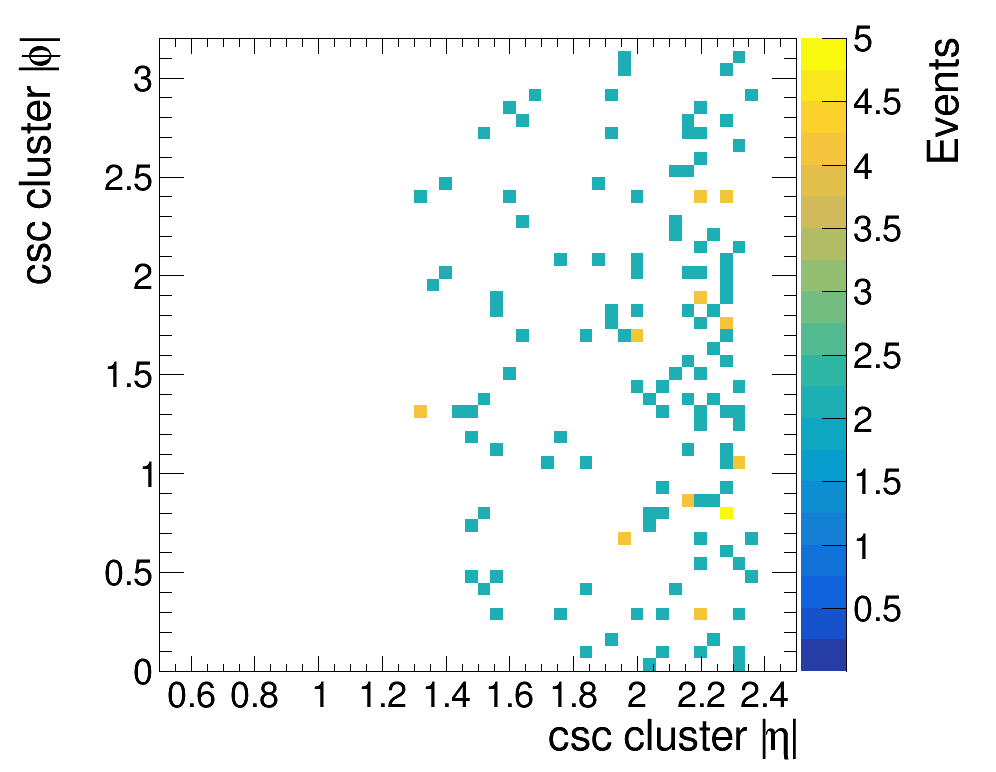

In [251]:
assert(category == 0 or category ==2)


c = rt.TCanvas('c','c', 1000, 800)
leg = rt.TLegend(0.6,0.7,0.80,0.92)


leg.SetTextSize(0.03)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)
h = {}
k= 'data'
timecut = 1
if category == 0:
    sel_csccluster =  cscClusterSize[k]<1000000
    if timecut:
        sel_csccluster =  np.logical_and(sel_csccluster, cscRechitClusterTimeWeighted[k]<12.5)
        sel_csccluster =  np.logical_and(sel_csccluster, cscRechitClusterTimeWeighted[k]>-5)

    cond = sel_csccluster.sum()==2
else:
    sel_csccluster = cscClusterSize[k]>=0
    cond =  np.logical_or(cscClusterSize[k]<100, dtRechitClusterSize[k]<80)
    cond = np.logical_and(cond, np.logical_and(cscRechitClusterTimeWeighted[k]<12.5, cscRechitClusterTimeWeighted[k]>-5))       
cond= np.logical_and(cond, cscClusterSize[k].min()<100)
if category == 0:
    eta = np.abs(np.hstack((cscRechitClusterEta[k][sel_csccluster][cond][:,0], cscRechitClusterEta[k][sel_csccluster][cond][:,1])))
    phi = np.abs(np.hstackack((cscRechitClusterPhi[k][sel_csccluster][cond][:,0], cscRechitClusterPhi[k][sel_csccluster][cond][:,1])))
else:
    eta = np.abs(np.hstack((cscRechitClusterEta[k][cond], cscRechitClusterEta[k][cond])))
    phi = np.abs(np.hstack((cscRechitClusterPhi[k][cond], cscRechitClusterPhi[k][cond])))
h[k] = create_TH2D(np.column_stack((eta,phi)), axis_title = ['csc cluster |#eta|','csc cluster |#phi|', 'Events'], binning = [50,0.5,2.5,50,0,3.2])

h[k].SetMaximum(5)
h[k].SetMinimum(1e-3)

h[k].Draw('colz')


#     leg.Draw()
c.SetRightMargin(0.2)


# c.SetLogz()
c.Draw()
plot_path = '/storage/af/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/double_tag/selection_plots_final/'
# if timecut:
#     c.SaveAs(plot_path+v2+'/csccsc_etaphi_intime.png')
#     c.SaveAs(plot_path+v2+'/csccsc_etaphi_intime.pdf')
#     c.SaveAs(plot_path+v2+'/csccsc_etaphi_intime.C')
# else:
#     c.SaveAs(plot_path+v2+'/csccsc_etaphi.png')
#     c.SaveAs(plot_path+v2+'/csccsc_etaphi.pdf')
#     c.SaveAs(plot_path+v2+'/csccsc_etaphi.C')



# DT Cluster Plots

[[1.0] [1.0]]
[[52] [41]]
[[5] [8]]
[[0] [3]]
[[5] [2]]


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /storage/af/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/double_tag/selection_plots_final//v1/v163/dtdt_clusterDPhi.png has been created
Info in <TCanvas::Print>: pdf file /storage/af/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/double_tag/selection_plots_final//v1/v163/dtdt_clusterDPhi.pdf has been created
Info in <TCanvas::SaveSource>: C++ Macro file: /storage/af/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/double_tag/selection_plots_final//v1/v163/dtdt_clusterDPhi.C has been generated


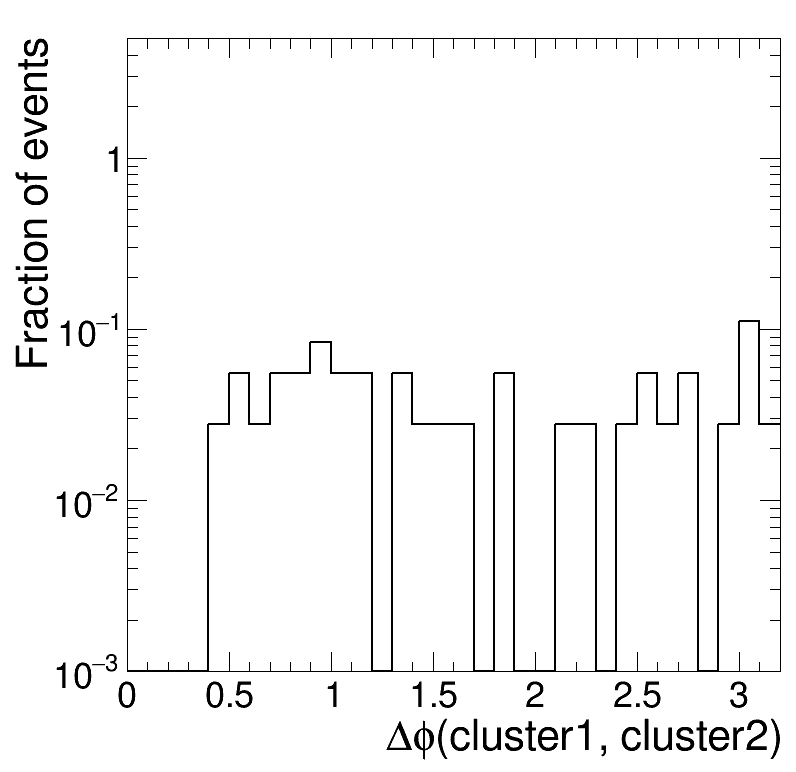

In [282]:
assert(category == 1)

var = [dtRechitCluster_match_RPCBx_dPhi0p5, dtRechitClusterEta, dtRechitClusterAvgStation, dtRechitClusterPhi]
name = ['dtRechitCluster_match_RPCBx_dPhi0p5', 'dtRechitClusterEta', 'dtRechitClusterAvgStation', 'clusterDPhi']
xaxis = ['dt cluster BX', 'cluster #eta', 'DT cluster average station', '#Delta#phi(cluster1, cluster2)']


bins = [[10,-5,5], [20,0,1], [20,1,5],[32,0,3.2]]
setlogy = [1,1,1,1,1,1,0,0,1,1,1,1,1]



for index in range(len(var)):
    if not index == 3:continue
    c = rt.TCanvas('c','c', 800, 800)
    leg = rt.TLegend(0.5,0.7,0.75,0.92)
    leg.SetTextSize(0.03)
    leg.SetBorderSize(0)
    leg.SetEntrySeparation(0.01)
    h = {}

    for i, k in enumerate(dtRechitClusterEta.keys()):
#         if not k[-4:] == '1000' and not k == 'data':continue
        if not k == 'data':continue

        sel_dtcluster =  dtRechitClusterSize[k]<800000
#         if index == 2: sel_dtcluster = np.abs(dtRechitClusterMetEENoise_dPhi[k])<1
        cond = sel_dtcluster.sum()==2
        cond= np.logical_and(cond, dtRechitClusterSize[k].min()<80)
        
        if index <= 2: h[k] = create_TH1D(np.hstack((var[index][k][sel_dtcluster][cond][:,0], var[index][k][sel_dtcluster][cond][:,1])), axis_title = [xaxis[index], 'Fraction of events'], binning = bins[index])
        else: #deltaphi between clusters
            h[k] = create_TH1D(np.abs(deltaPhi(var[index][k][sel_dtcluster][cond][:,0], var[index][k][sel_dtcluster][cond][:,1])), axis_title = [xaxis[index], 'Fraction of events'], binning = bins[index])
        h[k].SetLineColor(std_color_list[i])
        if h[k].Integral()>0:h[k].Scale(1./h[k].Integral())
        sel_dtcluster = np.logical_and(sel_dtcluster, dtRechitClusterAvgStation[k] < 1.1)
        cond = np.logical_and(cond, dtRechitClusterAvgStation[k].min()<1.1)
#         cond= np.logical_and(cond, dtRechitClusterSize[k].min()<80)
        print(dtRechitClusterAvgStation[k][sel_dtcluster][cond])
        print(dtRechitClusterNSegmentStation1[k][sel_dtcluster][cond])
        print(dtRechitClusterNSegmentStation2[k][sel_dtcluster][cond])
        print(dtRechitClusterNSegmentStation3[k][sel_dtcluster][cond])
        print(dtRechitClusterNSegmentStation4[k][sel_dtcluster][cond])
        h[k].SetMaximum(5)
        h[k].SetMinimum(0.001)
        h[k].Draw('hist same')

#     leg.Draw()
    # if setlog: 
    c.SetLogy()
    c.Draw()
    plot_path = '/storage/af/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/double_tag/selection_plots_final/'+v2+'/'
    if not os.path.exists(plot_path):os.makedirs(plot_path)
    c.SaveAs(plot_path+'dtdt_'+name[index]+".png")
    c.SaveAs(plot_path+'dtdt_'+name[index]+".pdf")
    c.SaveAs(plot_path+'dtdt_'+name[index]+".C")




# DT-CSC plots

data 140.0


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /storage/af/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/double_tag/selection_plots_final//v1/v163/dtcsc_clusterDPhi.png has been created
Info in <TCanvas::Print>: pdf file /storage/af/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/double_tag/selection_plots_final//v1/v163/dtcsc_clusterDPhi.pdf has been created
Info in <TCanvas::SaveSource>: C++ Macro file: /storage/af/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/double_tag/selection_plots_final//v1/v163/dtcsc_clusterDPhi.C has been generated


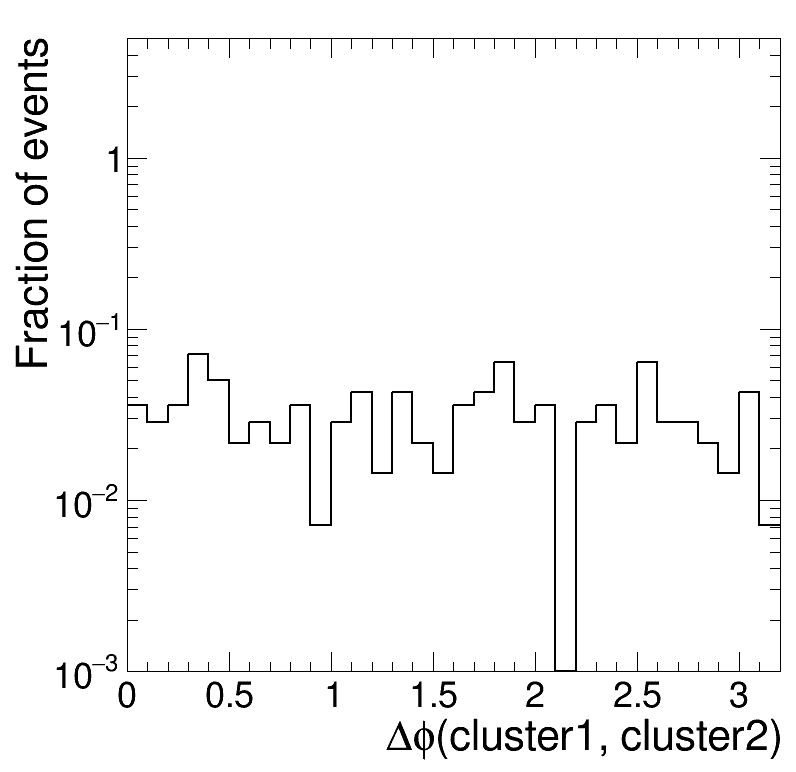

In [288]:
assert(category==2)



var = [dtRechitCluster_match_RPCBx_dPhi0p5, dtRechitClusterEta, dtRechitClusterAvgStation,cscRechitClusterTimeWeighted, cscRechitClusterEta, dtRechitClusterPhi, cscRechitClusterAvgStation]
name = ['dtRechitCluster_match_RPCBx_dPhi0p5', 'dtRechitClusterEta', 'dtRechitClusterAvgStation','cscRechitClusterTimeWeighted', 'cscRechitClusterEta', 'clusterDPhi', 'cscRechitClusterAvgStation']
xaxis = ['dt cluster BX', 'cluster #eta', 'DT cluster average station', 'cluster time [ns]', 'cluster #eta', '#Delta#phi(cluster1, cluster2)', 'CSC cluster average station']


bins = [[10,-5,5], [20,0,1], [20,1,5],  [100,-100,120], [25,0.8,2.5], [32,0,3.2], [20,1,5]]
# setlogy = [1,1,1,1,1,1,0,0,1,1,1,1]




for index in range(len(var)):
    if not index == 5:continue
    c = rt.TCanvas('c','c', 800, 800)
    leg = rt.TLegend(0.6,0.7,0.8,0.92)
    leg.SetTextSize(0.03)
    leg.SetBorderSize(0)
    leg.SetEntrySeparation(0.01)
    h = {}

    for i, k in enumerate(cscClusterSize.keys()):
#         if not k[-4:] == '1000' and not k == 'data':continue
        if k == 'data':cond =  np.logical_or(cscClusterSize[k]<100, dtRechitClusterSize[k]<80)
        else: cond =  cscClusterSize[k]>=50
        if not index == 3: 
            cond = np.logical_and(cond, np.logical_and(cscRechitClusterTimeWeighted[k]<12.5, cscRechitClusterTimeWeighted[k]>-5))

        if index == 0 or index == 3:h[k] = create_TH1D(var[index][k], axis_title = [xaxis[index], 'Fraction of events'], binning = bins[index])
        elif index == 5:h[k] = create_TH1D(np.abs(deltaPhi(dtRechitClusterPhi[k][cond], cscRechitClusterPhi[k][cond])), axis_title = [xaxis[index], 'Fraction of events'], binning = bins[index])
        else:h[k] = create_TH1D(np.abs(var[index][k][cond]), axis_title = [xaxis[index], 'Fraction of events'], binning = bins[index])
        print(k,h[k].Integral())
        h[k].SetLineColor(std_color_list[i])
        if h[k].Integral()>0:h[k].Scale(1./h[k].Integral())

        h[k].SetMaximum(5)

        h[k].SetMaximum(5)
        h[k].SetMinimum(1e-3)
          
#         cond = np.logical_and(cond, dtRechitClusterAvgStation[k] == 1)
#         print(dtRechitClusterAvgStation[k][cond])
#         print(dtRechitClusterNSegmentStation1[k][cond])
#         print(dtRechitClusterNSegmentStation2[k][cond])
#         print(dtRechitClusterNSegmentStation3[k][cond])
#         print(dtRechitClusterNSegmentStation4[k][cond])
        
        h[k].Draw('hist same')

        


    # if setlog: 
    c.SetLogy()
    c.Draw()
    plot_path = '/storage/af/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/double_tag/selection_plots_final/'+v2+'/'
    if not os.path.exists(plot_path):os.makedirs(plot_path)
    c.SaveAs(plot_path+'dtcsc_'+name[index]+".png")
    c.SaveAs(plot_path+'dtcsc_'+name[index]+".pdf")
    c.SaveAs(plot_path+'dtcsc_'+name[index]+".C")


In [271]:
category

2

# DT Noise Hits

Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).


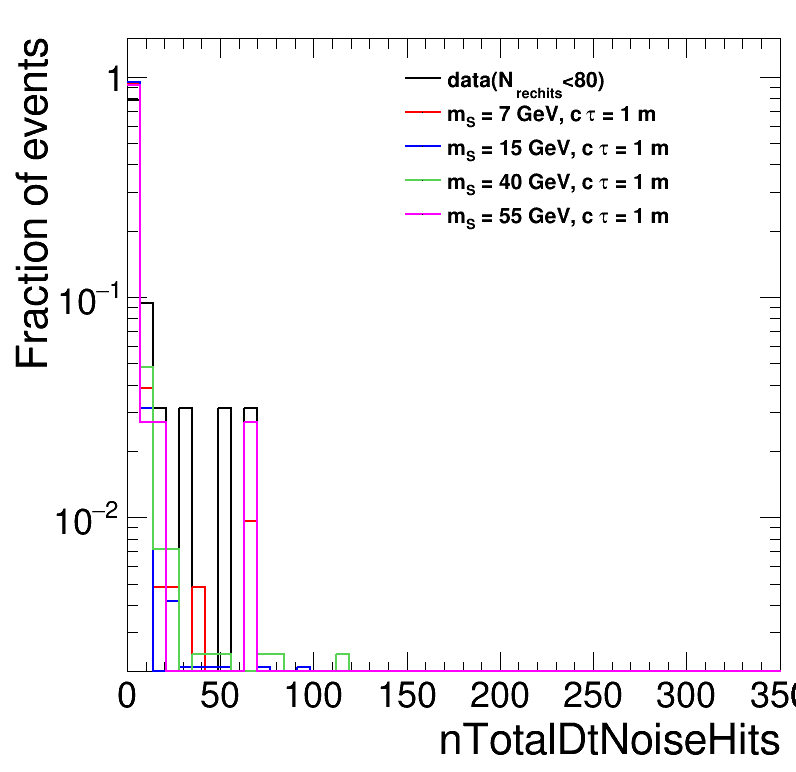

In [29]:
assert(category == 1)


var = [nTotalDtNoiseHits, nDTRechitsNoiseSec8, nDTRechitsNoiseSec9, nDTRechitsNoiseSec10]

name = ['nTotalDtNoiseHits', 'nDTRechitsNoiseSec8', 'nDTRechitsNoiseSec9', 'nDTRechitsNoiseSec10']
xaxis = ['nTotalDtNoiseHits', 'nDTRechitsNoiseSec8', 'nDTRechitsNoiseSec9', 'nDTRechitsNoiseSec10']

bins = [ [50,0,350]]*4


for index in range(len(var)):
    if not index == 0:continue
    c = rt.TCanvas('c','c', 800, 800)
    leg = rt.TLegend(0.5,0.7,0.75,0.92)
    leg.SetTextSize(0.03)
    leg.SetBorderSize(0)
    leg.SetEntrySeparation(0.01)
    h = {}

    for i, k in enumerate(weight.keys()):
        if not k[-4:] == '1000' and not k == 'data':continue
        if k == 'data':sel_dtcluster =  dtClusterSize[k]<80
        else: sel_dtcluster = dtClusterSize[k]>=80
        sel_dtcluster = np.logical_and(sel_dtcluster, dtRechitCluster_match_RPChits_dPhi0p5[k]>=1)
        sel_dtcluster = np.logical_and(sel_dtcluster, dtRechitClusterJetVetoPt[k]<50)
        sel_dtcluster = np.logical_and(sel_dtcluster, np.abs(dtRechitClusterDphi[k])<1.2)
        cond = sel_dtcluster.sum()==2

        h[k] = create_TH1D(np.abs(var[index][k][cond]), axis_title = [xaxis[index], 'Fraction of events'], binning = bins[index])
        #     print(k, np.count_nonzero(var[index][k][sel_csccluster][cond].max()<30)/np.count_nonzero(cond))
        if k == 'data':leg.AddEntry(h[k],k+'(N_{rechits}<80)')
        else: leg.AddEntry(h[k],'m_{S} = ' + k[k.find('m')+1:k.find('ctau')] + ' GeV, c#tau = 1 m')

#         if index == 0:print(k, np.count_nonzero(var[index][k][sel_dtcluster][cond].min()>=1)/np.count_nonzero(cond))
#         elif index == 1:print(k, np.count_nonzero(var[index][k][sel_dtcluster][cond].max()<50)/np.count_nonzero(cond))
#         elif index == 2:print(k, np.count_nonzero(np.abs(var[index][k][sel_dtcluster][cond]).max()<1)/np.count_nonzero(cond))
#         elif index == 3:print(k, np.count_nonzero(np.abs(var[index][k][sel_dtcluster][cond]).max()<0.9)/np.count_nonzero(cond))

        h[k].SetLineColor(std_color_list[i])
        if h[k].Integral()>0:h[k].Scale(1./h[k].Integral())

        if index == 4:h[k].SetMaximum(5)
        else: h[k].SetMaximum(1.5)
        h[k].SetMinimum(0.002)
        h[k].Draw('hist same')
    leg.Draw()
#     c.SetRightMargin(0.2)


    # if setlog: 
    c.SetLogy()
    c.Draw()
    plot_path = '/storage/af/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/double_tag/selection_plots'
#     c.SaveAs(plot_path+v2+'/'+name[index]+".png")
#     c.SaveAs(plot_path+v2+'/'+name[index]+".pdf")
#     c.SaveAs(plot_path+v2+'/'+name[index]+".C")



